# Phase 3: Advanced Feature Engineering

Objective:
To generate habitability and stability indices, perform encoding,
scaling, and prepare the final ML-ready dataset as per the PDF.


In [1]:
#PHASE 3 — STEP 1: MISSING VALUE HEATMAP
#STEP 1.1: Load Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#STEP 1.2: Load Phase 2 Dataset
df = pd.read_csv("../data/processed/preprocessed_phase2.csv")
df.shape


(314950, 16)

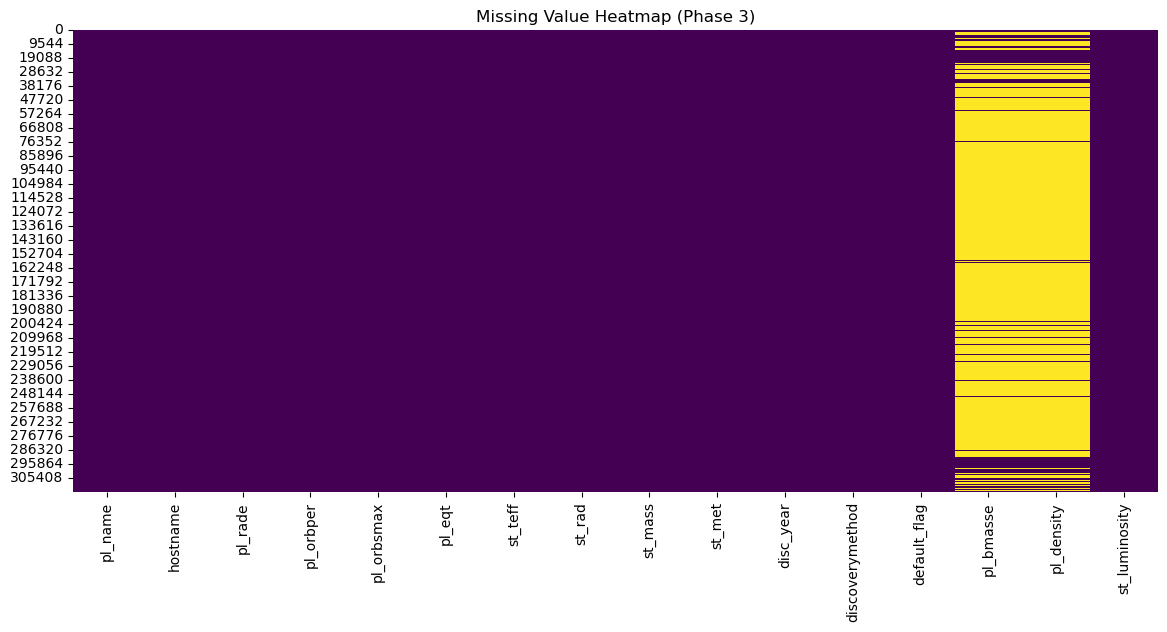

In [3]:
#STEP 1.3: Generate Missing Value Heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Value Heatmap (Phase 3)")
plt.show()


In [4]:
#PHASE 3 — STEP 2: OUTLIER DETECTION (IQR METHOD)
#STEP 2.1: Select Numerical Columns for Outlier Detection
numeric_cols = [
    'pl_rade',
    'pl_eqt',
    'pl_orbper',
    'pl_orbsmax',
    'st_teff',
    'st_rad',
    'st_luminosity'
]


In [5]:
#STEP 2.2: Define IQR Outlier Function
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]


In [6]:
#STEP 2.3: Apply IQR Filtering
df_before = df.shape

for col in numeric_cols:
    df = remove_outliers_iqr(df, col)

df_after = df.shape

df_before, df_after


((314950, 16), (115617, 16))

In [7]:
#PHASE 3 — STEP 3: HABITABILITY SCORE INDEX
#STEP 3.1: Normalize Required Features (0–1 scale)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df[['pl_eqt_norm',
    'pl_rade_norm',
    'pl_orbsmax_norm',
    'st_luminosity_norm']] = scaler.fit_transform(
    df[['pl_eqt', 'pl_rade', 'pl_orbsmax', 'st_luminosity']]
)


In [8]:
#STEP 3.2: Define Habitability Conditions
df['temp_score'] = 1 - abs(df['pl_eqt'] - 288) / 288
df['radius_score'] = 1 - abs(df['pl_rade'] - 1)
df['distance_score'] = 1 - df['pl_orbsmax_norm']
df['luminosity_score'] = 1 - df['st_luminosity_norm']


In [9]:
#STEP 3.3: Create Habitability Score Index
df['habitability_index'] = (
    df['temp_score'] +
    df['radius_score'] +
    df['distance_score'] +
    df['luminosity_score']
) / 4


In [10]:
#STEP 3.4: Inspect Habitability Index
df['habitability_index'].describe()


count    115617.000000
mean          0.174857
std           0.131173
min          -0.384571
25%           0.108989
50%           0.175656
75%           0.218034
max           0.551675
Name: habitability_index, dtype: float64

In [11]:
#PHASE 3 — STEP 4: STELLAR COMPATIBILITY INDEX
#STEP 4.1: Normalize Stellar Features
df[['st_teff_norm',
    'st_rad_norm',
    'st_lum_norm']] = scaler.fit_transform(
    df[['st_teff', 'st_rad', 'st_luminosity']]
)


In [12]:
#STEP 4.2: Define Stellar Compatibility Scores
df['temp_star_score'] = 1 - abs(df['st_teff'] - 5778) / 5778
df['size_star_score'] = 1 - df['st_rad_norm']
df['radiation_score'] = 1 - df['st_lum_norm']


In [13]:
#STEP 4.3: Create Stellar Compatibility Index
df['stellar_compatibility_index'] = (
    df['temp_star_score'] +
    df['size_star_score'] +
    df['radiation_score']
) / 3


In [14]:
#STEP 4.4: Inspect the Index
df['stellar_compatibility_index'].describe()


count    115617.000000
mean          0.710193
std           0.121245
min           0.348487
25%           0.655745
50%           0.757825
75%           0.799235
max           0.990481
Name: stellar_compatibility_index, dtype: float64

In [15]:
#PHASE 3 — STEP 5: ORBITAL STABILITY FACTOR
#STEP 5.1: Normalize Orbital Features
df[['pl_orbper_norm', 'pl_orbsmax_norm']] = scaler.fit_transform(
    df[['pl_orbper', 'pl_orbsmax']]
)


In [16]:
#STEP 5.2: Define Orbital Stability Scores
df['period_stability_score'] = 1 - abs(df['pl_orbper_norm'] - 0.5)
df['distance_stability_score'] = 1 - df['pl_orbsmax_norm']


In [17]:
#STEP 5.3: Create Orbital Stability Factor
df['orbital_stability_factor'] = (
    df['period_stability_score'] +
    df['distance_stability_score']
) / 2


In [18]:
#STEP 5.4: Inspect the Factor
df['orbital_stability_factor'].describe()


count    115617.000000
mean          0.851469
std           0.061190
min           0.750000
25%           0.799345
50%           0.858798
75%           0.885695
max           0.999691
Name: orbital_stability_factor, dtype: float64

In [19]:
#PHASE 3 — STEP 6: CATEGORICAL ENCODING (STAR TYPES)
def classify_star(teff):
    if teff < 3700:
        return 'M'
    elif teff < 5200:
        return 'K'
    elif teff < 6000:
        return 'G'
    else:
        return 'F'

df['star_type'] = df['st_teff'].apply(classify_star)


In [20]:
#STEP 6.2: Check Star Type Distribution
df['star_type'].value_counts()


star_type
G    72634
K    28412
F    14571
Name: count, dtype: int64

In [21]:
#STEP 6.3: One-Hot Encode Star Types
df = pd.get_dummies(df, columns=['star_type'], prefix='star')


In [22]:
#STEP 6.4: Verify Encoding
[col for col in df.columns if col.startswith('star_')]


['star_F', 'star_G', 'star_K']

In [23]:
#PHASE 3 — STEP 7: FEATURE SCALING
#STEP 7.1: Select Features to Scale
from sklearn.preprocessing import StandardScaler

scale_cols = [
    'pl_rade',
    'pl_eqt',
    'pl_orbper',
    'pl_orbsmax',
    'st_teff',
    'st_rad',
    'st_luminosity',
    'pl_density',
    'habitability_index',
    'stellar_compatibility_index',
    'orbital_stability_factor'
]


In [24]:
#STEP 7.2: Apply Standard Scaling
scaler_std = StandardScaler()

df[scale_cols] = scaler_std.fit_transform(df[scale_cols])


In [25]:
#STEP 7.3: Verify Scaling
df[scale_cols].describe()


pl_rade    pl_eqt     pl_orbper    pl_orbsmax       st_teff  \
count  1.156170e+05  115617.0  1.156170e+05  1.156170e+05  1.156170e+05   
mean  -3.618564e-16       0.0  7.079800e-17  5.551115e-17 -1.061970e-16   
std    1.000004e+00       0.0  1.000004e+00  0.000000e+00  1.000004e+00   
min   -3.066565e+00       0.0 -1.228518e+00  5.551115e-17 -2.949829e+00   
25%    1.653822e-01       0.0 -7.250425e-01  5.551115e-17 -5.412823e-01   
50%    1.653822e-01       0.0 -1.627876e-01  5.551115e-17  2.575625e-01   
75%    1.653822e-01       0.0  2.933319e-01  5.551115e-17  6.559838e-01   
max    3.514461e+00       0.0  3.603285e+00  5.551115e-17  2.834287e+00   

             st_rad  st_luminosity    pl_density  habitability_index  \
count  1.156170e+05   1.156170e+05  10168.000000        1.156170e+05   
mean  -3.539900e-16  -1.966611e-18      0.000000        1.769950e-16   
std    1.000004e+00   1.000004e+00      1.000049        1.000004e+00   
min   -3.060115e+00  -1.287342e+00     -0.189542       -4.264842e+00   
25%   -7.473129e-01  -7.825815e-01     -0.185611       -5.021514e-01   
50%   -1.959147e-01  -2.816337e-01     -0.164500        6.091269e-03   
75%    5.447976e-01   4.989395e-01     -0.037953        3.291604e-01   
max    3.191912e+00   2.905820e+00     68.186581        2.872700e+00   

       stellar_compatibility_index  orbital_stability_factor  
count                 1.156170e+05              1.156170e+05  
mean                 -1.170134e-16             -2.851586e-16  
std                   1.000004e+00              1.000004e+00  
min                  -2.983285e+00             -1.658253e+00  
25%                  -4.490758e-01             -8.518306e-01  
50%                   3.928593e-01              1.197856e-01  
75%                   7.344037e-01              5.593382e-01  
max                   2.311764e+00              2.422324e+00

STEP 8.1: Decide Target Type (PDF allows both)

We will create a Binary Target Variable (simplest & safest):

1 → Potentially Habitable

0 → Not Habitable

Based on:

Habitability Score Index

In [26]:
#STEP 8.2: Define Threshold
threshold = df['habitability_index'].median()


In [27]:
#STEP 8.3: Create Target Variable
df['habitable'] = (df['habitability_index'] > threshold).astype(int)


In [28]:
#STEP 8.4: Check Target Distribution
df['habitable'].value_counts()


habitable
0    57815
1    57802
Name: count, dtype: int64

In [31]:
df.shape

(115617, 40)

In [32]:
df.to_csv("../data/processed/preprocessed_phase3.csv", index=False)
print("Phase 3 dataset saved successfully.")


Phase 3 dataset saved successfully.
